# Cramer-Wold AutoEncoder
This notebook illustrates how to construct, train and evaluate basic Cramer-Wold AutoEncoder model as described in paper: https://arxiv.org/pdf/1805.09235.pdf

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.logging.set_verbosity(tf.logging.ERROR)

## MNIST dataset
In this Notebook we are going to use MNIST dataset. In order to load it, we will use Tensorflow's built-in functions. Dataset consists of handwritten digits each image of shape 28x28. In downloaded dataset each pixel is in the range between 0 and 255 for simplicity we will map this data to range between 0.0 and 1.0

In [2]:
(tr_images, _), (validation_images, _) = tf.keras.datasets.mnist.load_data()
tr_images = tr_images.astype(np.float32) / 255.0
validation_images = validation_images.astype(np.float32) / 255.0

## AutoEncoder architecture and reconstruction error
The basic aim of AE is to transport the data to a typically, but not necessarily, lower dimensional latent space $Z=R^D$ while minimizing the reconstruction error. Thus, we search for an encoder $E:R^n$ to $Z$ and decoder $D:Z$ to $R^n$ functions, which minimize the reconstruction error on the data set $X$:
\begin{equation*}
MSE(X;E,D)=\frac{1}{n}\sum_{i=1}^n \|x_i-D(E(x_i))\|^2.
\end{equation*}

In [3]:
def encoder_builder(x):
    hidden_layer_neurons_count = 200
    hidden_layers_count = 3
    z_dim = 2
    
    h = tf.layers.flatten(x)
    for i in range(hidden_layers_count):
        h = tf.layers.dense(h, hidden_layer_neurons_count, activation=tf.nn.relu, name=f'Encoder_{i}')

    return tf.layers.dense(h, z_dim, name=f'Encoder_output')

def decoder_builder(z):
    hidden_layer_neurons_count = 200
    hidden_layers_count = 3
        
    h = z
    for i in range(hidden_layers_count):
        h = tf.layers.dense(h, hidden_layer_neurons_count, activation=tf.nn.relu, name=f'Decoder_{i}')

    h = tf.layers.dense(h, units=28*28, activation=tf.nn.sigmoid, name='Output')
    h = tf.reshape(h, [-1, 28, 28])
    return h

def reconstruction_error(x, y):
    diff = tf.layers.flatten(x) - tf.layers.flatten(y)
    return tf.reduce_mean(tf.reduce_sum(tf.square(diff), axis=1))

tensor_input_x = tf.placeholder(shape=[None, 28, 28], dtype=tf.float32)
tensor_z = encoder_builder(tensor_input_x)
tensor_output_x = decoder_builder(tensor_z)

##  Cramer-Wold distance

To ensure that the data transported to the latent space $Z$ are distributed according to the standard normal density, we add to the cost function Cramer-Wold distance from standard multivariate normal density as defined in the original paper:

In [4]:
def cw_distance(Z):
    
    def euclidean_norm_squared(X, axis=None):
        return tf.reduce_sum(tf.square(X), axis=axis)
    D = tf.cast(tf.shape(Z)[1], tf.float32)
    N = tf.cast(tf.shape(Z)[0], tf.float32)
    y = tf.pow(4/(3*N), 0.4)

    K = 1/(2*D-3)

    A1 = euclidean_norm_squared(tf.subtract(tf.expand_dims(Z, 0), tf.expand_dims(Z, 1)), axis=2)
    A = (1/(N**2)) * tf.reduce_sum((1/tf.sqrt(y + K*A1)))

    B1 = euclidean_norm_squared(Z, axis=1)
    B = (2/N)*tf.reduce_sum((1/tf.sqrt(y + 0.5 + K*B1)))

    return (1/tf.sqrt(1+y)) + A - B

## Cost function
Cramer-Wold AutoEncoder's cost function is defined as follows:

\begin{equation*} \label{eq:cost}
\mathrm{cost}(X;E,D)=\log d^2_{CW}(E(X),N(0,I)) + MSE(X;E,D).
\end{equation*}

In [5]:
tensor_rec_error = reconstruction_error(tensor_input_x, tensor_output_x)
tensor_cw_distance = cw_distance(tensor_z)
tensor_cwae_cost_function = tensor_rec_error + tf.log(tensor_cw_distance)

## Training process

In [6]:
optimizer = tf.train.AdamOptimizer()
train_ops = optimizer.minimize(tensor_cwae_cost_function)      

In [8]:
epochs_count = 150
batch_size = 128
report_after_epoch = 10

cw_distances = list()
reconstruction_errors = list()
epochs = list()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(1, epochs_count+1):
        
    np.random.shuffle(tr_images)
    for b in np.array_split(tr_images, batch_size):
        sess.run(train_ops, feed_dict={tensor_input_x: b})
        
    should_report = (i == epochs_count) or (i==1) or (i % report_after_epoch == 0)
    if should_report:
        rec_error, cw_distance, cost = sess.run([tensor_rec_error, tensor_cw_distance, tensor_cwae_cost_function], feed_dict={tensor_input_x: validation_images})
        print('Epoch ', i, 'Rec error: ', rec_error, 'CW distance: ', cw_distance, 'Cost: ', cost)
        
        cw_distances.append(cw_distance)
        reconstruction_errors.append(rec_error)
        epochs.append(i)

Epoch  1 Rec error:  43.429092 CW distance:  0.87936616 Cost:  43.300537
Epoch  10 Rec error:  31.740662 CW distance:  0.23912704 Cost:  30.309902
Epoch  20 Rec error:  29.478045 CW distance:  0.23878384 Cost:  28.045849
Epoch  30 Rec error:  28.802237 CW distance:  0.24720192 Cost:  27.404686
Epoch  40 Rec error:  27.610138 CW distance:  0.23992527 Cost:  26.18271
Epoch  50 Rec error:  27.5984 CW distance:  0.23783171 Cost:  26.162209
Epoch  60 Rec error:  27.380552 CW distance:  0.24260068 Cost:  25.964214
Epoch  70 Rec error:  27.093584 CW distance:  0.24524939 Cost:  25.688105
Epoch  80 Rec error:  26.909883 CW distance:  0.23962522 Cost:  25.481205
Epoch  90 Rec error:  26.780071 CW distance:  0.24046409 Cost:  25.354887
Epoch  100 Rec error:  26.486553 CW distance:  0.2392689 Cost:  25.056385
Epoch  110 Rec error:  26.438818 CW distance:  0.24313056 Cost:  25.024662
Epoch  120 Rec error:  26.190504 CW distance:  0.24328256 Cost:  24.776972
Epoch  130 Rec error:  26.050795 CW dist

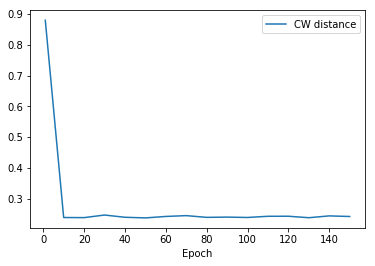

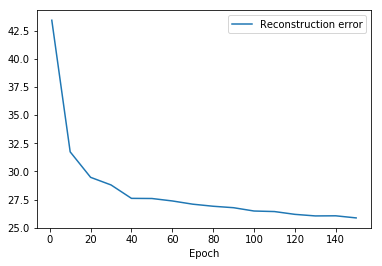

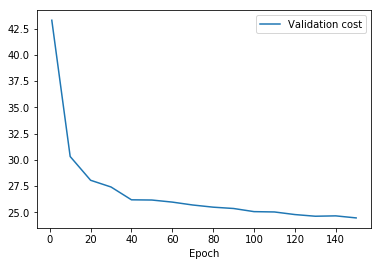

In [9]:
plt.plot(epochs, cw_distances, label='CW distance')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(epochs, reconstruction_errors, label='Reconstruction error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(epochs, reconstruction_errors + np.log(cw_distances), label='Validation cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Sampled images

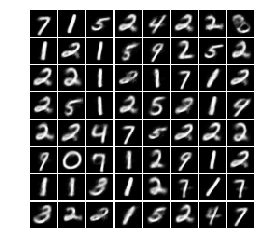

In [10]:
x = np.random.multivariate_normal([1.0, 1.0], [[1.0, 0.0], [0.0, 1.0]], 64)
decoded_images = sess.run(tensor_output_x, feed_dict={tensor_z: x})
fig = plt.figure(figsize=(4, 4)) 
plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.axis('off')
for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1,)
    sub.axis('off')
    sub.imshow(decoded_images[i], cmap='gray')

## Interpolations

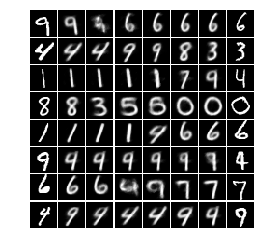

In [11]:
interpolations_step_count = 4
interpolations_count = 8

interpolation_indexes = list(np.reshape(np.random.randint(0, len(tr_images), interpolations_count * 2), [-1, 2]))
images = list()

for i, train_indexes in enumerate(interpolation_indexes):
    first_index = train_indexes[0]
    second_index = train_indexes[1]

    first_image = tr_images[first_index]
    second_image = tr_images[second_index]

    first_latent, first_image_decoded = sess.run([tensor_z, tensor_output_x], feed_dict={tensor_input_x: [first_image]})
    first_latent, first_image_decoded = first_latent[0], first_image_decoded[0]
    second_latent, second_latent_decoded = sess.run([tensor_z, tensor_output_x], feed_dict={tensor_input_x: [second_image]}) 
    second_latent, second_latent_decoded = second_latent[0], second_latent_decoded[0]
    images.extend([first_image, first_image_decoded])

    latent_step = (second_latent - first_latent) / (interpolations_step_count + 1)
    for j in range(interpolations_step_count):
        next_latent = first_latent + (j + 1) * latent_step
        next_image = sess.run(tensor_output_x, feed_dict={tensor_z: [next_latent]})[0]
        images.append(next_image)

    images.extend([second_latent_decoded, second_image])

fig = plt.figure(figsize=(4, 4)) 
plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.axis('off')
for i, img in enumerate(images):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.axis('off')
    sub.imshow(img, cmap='gray')

## Latent space map

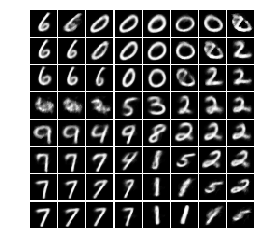

In [12]:
nx = ny = 8

x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

images = list()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        
        mu, sigma = 0, 1 

        yy = sess.run(tensor_output_x, { tensor_z: [[xi, yi]]})[0]
        images.append(yy)
        
fig = plt.figure(figsize=(4, 4)) 
plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.axis('off')
for i, img in enumerate(images):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.axis('off')
    sub.imshow(img, cmap='gray')